In [245]:
import sys
sys.path.append("../")

In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)  # Show all columns
import talib as tb
from sklearn.preprocessing import MinMaxScaler

import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

# Data Import

In [247]:
df_raw = pd.read_pickle("EUR_USD_H1.pkl")

# Constants

In [248]:
BUY = 1
SELL = -1
NONE = 0
SLIPPAGE = 0.002
PROFIT_FACTOR =20
LOSS_FACTOR =-30
open = "mid_o"
close = "mid_c"
high = "mid_h"
low = "mid_l"
volume = "volume"

# Create Indicators

In [249]:
def ATR(df: pd.DataFrame, n=14):
    prev_c = df.mid_c.shift(1)
    tr1 = df.mid_h - df.mid_l
    tr2 = abs(df.mid_h - prev_c)
    tr3 = abs(prev_c - df.mid_l)
    tr = pd.DataFrame({'tr1': tr1, 'tr2': tr2, 'tr3': tr3}).max(axis=1)
    df[f"ATR_{n}"] = tr.rolling(window=n).mean()
    return df

def SuperTrend(df: pd.DataFrame, n=10, multiplier=3):
    hl2 = (df.mid_h + df.mid_l) / 2
    df = ATR(df, n=n)
    df['basic_ub'] = hl2 + (multiplier * df[f"ATR_{n}"])
    df['basic_lb'] = hl2 - (multiplier * df[f"ATR_{n}"])
    df[f'final_ub_{n}'] = 0.0
    df[f'final_lb_{n}'] = 0.0
    df[f'SuperTrend_{n}'] = 0.0

    for i in range(n, len(df)):
        df[f'final_ub_{n}'].iat[i] = df['basic_ub'].iat[i] if df['basic_ub'].iat[i] < df[f'final_ub_{n}'].iat[i - 1] or df.mid_c.iat[i - 1] > df[f'final_ub_{n}'].iat[i - 1] else df[f'final_ub_{n}'].iat[i - 1]
        df[f'final_lb_{n}'].iat[i] = df['basic_lb'].iat[i] if df['basic_lb'].iat[i] > df[f'final_lb_{n}'].iat[i - 1] or df.mid_c.iat[i - 1] < df[f'final_lb_{n}'].iat[i - 1] else df[f'final_lb_{n}'].iat[i - 1]

        if df.mid_c.iat[i] > df[f'final_ub_{n}'].iat[i - 1]:
            df[f'SuperTrend_{n}'].iat[i] = df[f'final_ub_{n}'].iat[i]
        elif df.mid_c.iat[i] < df[f'final_lb_{n}'].iat[i - 1]:
            df[f'SuperTrend_{n}'].iat[i] = df[f'final_lb_{n}'].iat[i]
        else:
            df[f'SuperTrend_{n}'].iat[i] = df[f'SuperTrend_{n}'].iat[i - 1]

    return df

def CreateInc(dataset, close, high, low, volume):
    new_df = dataset.copy()
    # Moving Average
    new_df["SMA7"] = tb.SMA(dataset[close], timeperiod=7)
    new_df["SMA14"] = tb.SMA(dataset[close], timeperiod=14)
    new_df["SMA50"] = tb.SMA(dataset[close], timeperiod=50)
    new_df["SMA200"] = tb.SMA(dataset[close], timeperiod=200)
    m1 = max(new_df[new_df['SMA200'].isnull()].index)

    # Exponential Moving Average
    new_df["EMA7"] = tb.EMA(dataset[close], timeperiod=7)
    new_df["EMA14"] = tb.EMA(dataset[close], timeperiod=14)
    new_df["EMA50"] = tb.EMA(dataset[close], timeperiod=50)
    new_df["EMA200"] = tb.EMA(dataset[close], timeperiod=200)
    m2 = max(new_df[new_df['EMA200'].isnull()].index)

    # Moving Avarage Convergence Divergernce
    MACD12, macdsignal12, macdhist12 = tb.MACD(dataset[close], fastperiod=18, slowperiod=6, signalperiod=12)
    MACD24, macdsignal24, macdhist24 = tb.MACD(dataset[close], fastperiod=36, slowperiod=12, signalperiod=24)
    new_df["MACD12"] = MACD12
    new_df["MACD24"] = MACD24
    m3 = max(new_df[new_df['MACD24'].isnull()].index)

    # Relative Strength Index
    new_df["RSI12"] = tb.RSI(dataset[close], timeperiod=12)
    new_df["RSI24"] = tb.RSI(dataset[close], timeperiod=24)
    m4 = max(new_df[new_df['RSI24'].isnull()].index)

    # Average True Range
    new_df["ATR12"] = tb.ATR(dataset[high], dataset[low], dataset[close], timeperiod=12)
    new_df["ATR24"] = tb.ATR(dataset[high], dataset[low], dataset[close], timeperiod=24)
    m5 = max(new_df[new_df['ATR24'].isnull()].index)

    # Bolinger Bands
    upperband12, middleband12, lowerband12 = tb.BBANDS(dataset[close], timeperiod=12, nbdevup=2, nbdevdn=2, matype=0)
    upperband24, middleband24, lowerband24 = tb.BBANDS(dataset[close], timeperiod=24, nbdevup=2, nbdevdn=2, matype=0)
    new_df["Upperband12"] = upperband12
    new_df["Lowerband12"] = lowerband12
    new_df["Upperband24"] = upperband24
    new_df["Lowerband24"] = lowerband24
    m6 = max(new_df[new_df['Upperband24'].isnull()].index)

    # Volume Indicators
    new_df["OBV"] = tb.OBV(dataset[close], dataset[volume])
    # m8 = max(new_df[new_df["OBV"].isnull()].index)

    # Remove NaN values
    m = max(m1, m2, m3, m4, m5, m6)
    new_df = new_df.loc[m + 1:]
    new_df = new_df.reset_index()
    new_df = new_df.drop(columns=["index"])

    return new_df

# Feature Selection

In [250]:
drop_cols = ['bid_o', 'bid_h', 'bid_l', 'ask_o', 'ask_h', 'ask_l']
keep_cols = ['mid_o', 'mid_h', 'mid_l', 'mid_c', 'bid_c', 'ask_c']
df_raw.drop(drop_cols, axis=1, inplace=True)
df_raw

,time,volume,mid_o,mid_h,mid_l,mid_c,bid_c,ask_c
0,2015-01-07 00:00:00+00:00,719,1.18724,1.18816,1.18635,1.18697,1.18690,1.18704
1,2015-01-07 01:00:00+00:00,574,1.18698,1.18806,1.18681,1.18772,1.18766,1.18779
2,2015-01-07 02:00:00+00:00,356,1.18768,1.18792,1.18695,1.18702,1.18697,1.18708
3,2015-01-07 03:00:00+00:00,419,1.18702,1.18782,1.18666,1.18760,1.18755,1.18766
4,2015-01-07 04:00:00+00:00,301,1.18761,1.18781,1.18714,1.18755,1.18749,1.18761
...,...,...,...,...,...,...,...,...
57916,2024-04-29 19:00:00+00:00,3279,1.07246,1.07246,1.07150,1.07211,1.07204,1.07218
57917,2024-04-29 20:00:00+00:00,958,1.07210,1.07230,1.07195,1.07200,1.07191,1.07208
57918,2024-04-29 21:00:00+00:00,354,1.07220,1.07228,1.07200,1.07209,1.07197,1.07221
57919,2024-04-29 22:00:00+00:00,760,1.07212,1.07226,1.07170,1.07174,1.07166,1.07181


In [251]:
df_idc = CreateInc(df_raw,close,high,low,volume)

In [252]:
df_an = df_idc.copy()
df_slim = SuperTrend(df_an, n=100, multiplier=1.2)

In [253]:
df_slim.dropna(inplace=True)
df_slim.reset_index(drop=True, inplace=True)
df_slim

,time,volume,mid_o,mid_h,mid_l,mid_c,bid_c,ask_c,SMA7,SMA14,SMA50,SMA200,EMA7,EMA14,EMA50,EMA200,MACD12,MACD24,RSI12,RSI24,ATR12,ATR24,Upperband12,Lowerband12,Upperband24,Lowerband24,OBV,ATR_100,basic_ub,basic_lb,final_ub_100,final_lb_100,SuperTrend_100
0,2015-01-23 10:00:00+00:00,2564,1.12336,1.12461,1.12196,1.12349,1.12342,1.12356,1.130044,1.133121,1.149563,1.162097,1.128849,1.132962,1.145116,1.160884,-0.006888,-0.009960,14.528687,21.264761,0.003602,0.003330,1.141877,1.123135,1.158095,1.119001,-114740.0,0.002664,1.126482,1.120088,0.000000,0.000000,0.000000
1,2015-01-23 11:00:00+00:00,3209,1.12346,1.12480,1.11698,1.11734,1.11717,1.11752,1.127621,1.131744,1.148768,1.161760,1.125972,1.130879,1.144027,1.160451,-0.008110,-0.010871,11.040204,18.203568,0.003953,0.003517,1.143488,1.118629,1.155252,1.118065,-117949.0,0.002712,1.124144,1.117636,1.124144,1.117636,1.124144
2,2015-01-23 12:00:00+00:00,8862,1.11734,1.11990,1.11144,1.11868,1.11859,1.11876,1.125493,1.130435,1.147998,1.161436,1.124149,1.129253,1.143033,1.160035,-0.008404,-0.011377,15.843257,20.795902,0.004329,0.003723,1.143328,1.115876,1.151217,1.118398,-109087.0,0.002756,1.118977,1.112363,1.118977,1.112363,1.124144
3,2015-01-23 13:00:00+00:00,6365,1.11868,1.12362,1.11656,1.12354,1.12345,1.12363,1.124050,1.129637,1.147316,1.161139,1.123997,1.128491,1.142268,1.159672,-0.007463,-0.011202,30.656480,29.278396,0.004556,0.003862,1.142031,1.115066,1.147807,1.119081,-102722.0,0.002780,1.123426,1.116754,1.118977,1.116754,1.118977
4,2015-01-23 14:00:00+00:00,5943,1.12354,1.12616,1.12102,1.12441,1.12430,1.12452,1.122591,1.128798,1.146625,1.160846,1.124100,1.127947,1.141568,1.159321,-0.006480,-0.010882,32.960894,30.665446,0.004605,0.003915,1.140346,1.114769,1.146275,1.118787,-96779.0,0.002805,1.126956,1.120224,1.126956,1.120224,1.126956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57618,2024-04-29 19:00:00+00:00,3279,1.07246,1.07246,1.07150,1.07211,1.07204,1.07218,1.071741,1.071500,1.071624,1.068393,1.071931,1.071670,1.071302,1.069887,0.000402,0.000297,54.339369,52.809904,0.001245,0.001237,1.073109,1.069841,1.073227,1.069450,-916395.0,0.001087,1.073284,1.070676,1.073024,1.071230,1.073024
57619,2024-04-29 20:00:00+00:00,958,1.07210,1.07230,1.07195,1.07200,1.07191,1.07208,1.072041,1.071533,1.071610,1.068435,1.071948,1.071714,1.071330,1.069909,0.000361,0.000308,53.468553,52.392223,0.001171,0.001200,1.073141,1.070063,1.073156,1.069744,-917353.0,0.001080,1.073421,1.070829,1.073024,1.071230,1.073024
57620,2024-04-29 21:00:00+00:00,354,1.07220,1.07228,1.07200,1.07209,1.07197,1.07221,1.072156,1.071556,1.071593,1.068474,1.071984,1.071764,1.071360,1.069930,0.000341,0.000324,54.124742,52.711537,0.001097,0.001162,1.073212,1.070093,1.073095,1.070011,-916999.0,0.001074,1.073429,1.070851,1.073024,1.071230,1.073024
57621,2024-04-29 22:00:00+00:00,760,1.07212,1.07226,1.07170,1.07174,1.07166,1.07181,1.072164,1.071646,1.071567,1.068515,1.071923,1.071761,1.071375,1.069948,0.000254,0.000299,51.069416,51.314874,0.001052,0.001137,1.073209,1.070091,1.073053,1.070181,-917759.0,0.001074,1.073269,1.070691,1.073024,1.071230,1.073024


In [254]:
df_slim.isnull().sum()[df_slim.isnull().sum() > 0]

Series([], dtype: int64)

# Create signals - Do not run this if you dont want to  include

In [255]:
# def apply_signal(row):
#     if row.final_lb_100 != NONE and row.final_ub_100 != NONE:
#         if row.mid_c > row.final_ub_100:
#             return BUY
#         if row.mid_c < row.final_lb_100:
#             return SELL
#     return NONE   
# 
# df_slim["SIGNAL"] = df_slim.apply(apply_signal, axis=1)
# # Function to apply trade direction logic
# def apply_trade_direction(row, prev_non_zero_signal):
#     current_signal = row['SIGNAL']
#     if current_signal == 0:
#         return prev_non_zero_signal
#     elif prev_non_zero_signal is not None and current_signal == prev_non_zero_signal:
#         return prev_non_zero_signal
#     else:
#         return current_signal
#     
# # Variable to keep track of the last non-zero signal
# prev_non_zero_signal = None
# results = []
# 
# for index, row in df_slim.iterrows():
#     result = apply_trade_direction(row, prev_non_zero_signal)
#     results.append(result)
#     if row['SIGNAL'] != 0:
#         prev_non_zero_signal = row['SIGNAL']  # Update the last non-zero signal    
#         
# df_slim['Trade_Direction'] = results   
# df_slim["Trade_Direction"].value_counts()
# df_slim['Direction'] = df_slim['Trade_Direction'].diff().apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

# Calculate Ratios

In [256]:
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    mean_return = np.mean(returns)
    std_dev = np.std(returns)
    sharpe_ratio = (mean_return - risk_free_rate) / std_dev
    return sharpe_ratio

def calculate_sortino_ratio(returns, risk_free_rate=0.0):
    downside_returns = returns[returns < 0]
    downside_std_dev = np.std(downside_returns)
    mean_return = np.mean(returns)
    sortino_ratio = (mean_return - risk_free_rate) / downside_std_dev
    return sortino_ratio

def calculate_max_drawdown(cumulative_returns):
    peak = np.maximum.accumulate(cumulative_returns)
    if np.all(peak != 0):
        drawdown = (cumulative_returns - peak) / peak
        max_drawdown = drawdown.min()
        return max_drawdown
    else:
        return 0

# Class Model

In [257]:
class Trade:
    def __init__(self, row, trade_amount, pip_size, signal, profit_factor, loss_factor):
        self.running = True
        self.start_index = row.name
        self.start_price = row.mid_c
        self.trigger_price = row.mid_c
        self.result = 0.0
        self.profit = 0
        # self.end_time = row.time
        # self.start_time = row.time
        self.duration = 0
        self.reason_for_exit = None
        self.pip_size = pip_size
        self.signal = signal
         # Calculate TP and SL inside the class

        if self.signal == BUY:
            self.TP = self.start_price + (self.pip_size * profit_factor)
            self.SL =  self.start_price - (self.pip_size * loss_factor )
        elif self.signal == SELL:
            self.TP = self.start_price - (self.pip_size * profit_factor)
            self.SL =self.start_price + (self.pip_size * loss_factor)
        
        # Calculate the risk per trade in pips and the position size
        self.risk_per_trade_pips = abs(self.start_price - self.SL) / self.pip_size

        # Initialize initial cash and percent to trade
        self.trade_amount = trade_amount
        #trade properties
        self.trade_size_units = self.trade_size()
        self.trade_size_shares = self.trade_size_shares()

        # Validate SL and TP to ensure proper setup
        if (self.signal == BUY and self.SL >= self.start_price) or (self.signal == SELL and self.SL <= self.start_price):
            self.close_trade(row, None, self.start_price, "Slippage")

    def close_trade(self, row, result, trigger_price, reason,profit):
        self.running = False
        self.result = result
        self.profit = profit
        # self.end_time = row.time
        self.trigger_price = trigger_price
        self.reason_for_exit = reason
        
    def pip_value_per_units(self):
        return self.pip_size/self.start_price
    
    def trade_size(self):
        #returns the trade size in units 
        return self.trade_amount/(self.risk_per_trade_pips*self.pip_value_per_units())
    
    def trade_size_shares(self):
        return (self.trade_size_units*self.pip_size)/self.start_price

    def update(self, row):
        self.duration += 1
        if self.running :
            if self.signal == BUY:
                if row.mid_h >= self.TP:
                    result = (self.TP - self.start_price)/self.pip_size
                    profit = (result/self.risk_per_trade_pips)*self.trade_amount
                    self.close_trade(row, result, self.TP, 'Take_Profit', round(profit, 2))
                elif row.mid_c <= self.SL:
                    result = (self.SL - self.start_price)/self.pip_size
                    profit = (result/self.risk_per_trade_pips)*self.trade_amount
                    self.close_trade(row, result, self.SL, 'Stop_Loss', round(profit, 2))
            elif self.signal == SELL:
                if row.mid_l <= self.TP:
                    result = (self.start_price - self.TP) /self.pip_size
                    profit = (result/self.risk_per_trade_pips)*self.trade_amount
                    self.close_trade(row, result,  self.TP, 'Take_Profit',round(profit, 2))
                elif row.mid_c >= self.SL:
                    result = (self.start_price - self.SL)/self.pip_size #row.mid_h
                    profit = (result/self.risk_per_trade_pips)*self.trade_amount
                    self.close_trade(row, result, self.SL, 'Stop_Loss', round(profit, 2))

    def is_opposite(self, signal):
        return (self.signal == BUY and signal == SELL) or (self.signal == SELL and signal == BUY)


# Create Environment

In [258]:
def initialize_observation_space(observation_features):
    if observation_features is None:
        # default features if features not given
        observation_features = [
            'mid_c', 'SMA7', 'SMA14', 'SMA50',
            'EMA7', 'EMA14', 'EMA50', 'EMA200', 
            'MACD12', 'MACD23', 'ATR12', 'ATR24', 
            'OBV', 'Lowerband12', 'Upperband12', 'sharpe_ratio', 'cumulative_value', 
            'current_trade_value', 'cash'
        ]
    observation_space = gym.spaces.Box(
        low=-np.inf, high=np.inf, shape=(len(observation_features)+5,), dtype=np.float32)
    return observation_space

# return profit factor and loss factor according to action type.
'''
0.  No trade
i.	Buy with TP Level 1 and SL Level 1
ii.	Buy with TP Level 2 and SL Level 2
iii Buy with TP Level 3 and SL Level 3
iv.	Sell with TP Level 1 and SL Level 1
v.	Sell with TP Level 2 and SL Level 2
vi.	Sell with TP Level 3 and SL Level 3
'''
def get_loss_and_profit_factor(action_type):
    if action_type == 1 or action_type == 4:
        return 10,20
    elif action_type == 2 or action_type == 5:
        return 20,30
    elif action_type == 3 or action_type == 6:
        return 30,40
    else:
        return 10,10

'''
Action type 0 is for No trade
Action type 1,2,3 is for Buy trade
Action type 4,5,6 is for Sell trade
'''    
def action_signal_map(action_type):
    if action_type == 0:
        return NONE
    elif action_type == 1 or action_type == 2 or action_type == 3:
        return BUY
    elif action_type == 4 or action_type == 5 or action_type == 6:
        return SELL
    else:
        return None

## Environment implementation

In [259]:
'''
Change environmental variables when trades are closed only
No updates of shares
Profit or loss will be added to cash balance after trad is closed.
Similar to the previous implementation.
'''

class StockTradingEnv(gym.Env):
    def __init__(self, data, init_cash,recalc_period, observation_features=None):
        # Define the action space as a 2D vector representing the action type (buy or sell) and number of shares to trade
        self.recalc_period = recalc_period
        self.action_space = gym.spaces.MultiDiscrete([7, 11])  # [action, percentage of cash ]
        self.observation_features = observation_features
        # Create observation_space using given features - Enable customization
        self.observation_space = initialize_observation_space(observation_features)

        # Store the historical stock data, initial cash balance, and commission rate as instance variables
        self.data = data
        self.initial_cash = init_cash
        self.end_step = len(self.data) - 1
        # Reset the environment to its initial state
        self.reset()

    def reset(self, seed=0):
        # Set the current step to 0 and reset the state variables
        self.current_step = 0
        self.profits = 0
        self.returns = []
        self.cash = self.initial_cash # initial cash amount.
        self.cash_available = self.initial_cash # Available cash to trade
        self.prev_cash = 0
        self.sharpe_ratio = 0
        self.prev_sharpe_ratio = 0
        self.sortino_ratio = 0
        self.max_drawdown = 0
        self.open_trades = []
        self.close_trades = []
        self.metrics = []
        self.portfolio_values = []
        self.done = False
        # Return the initial observation
        return self._get_obs(),{}

    def step(self, action):
        # You can decide what should return by action. For example, I took action type with percentage of cash. then did the rest of implementation
        # If you need to return action type with number of shares, you need to change below if conditions and calculations accordingly.
        # I took cash percentage_to_trade since, it can be valid for any stock. 
        action_type, percentage_to_trade = action
        close_price = self.data.iloc[self.current_step][close]
        prev_close_price = self.data.iloc[self.current_step-1][close]

        # Close opposite trades
        if action_signal_map(action_type) != NONE:
            for ot in self.open_trades:
                if ot.is_opposite(action_signal_map(action_type)):
                    if ot.signal == BUY:
                        result = (close_price - ot.start_price) / ot.pip_size
                        profit = (result / ot.risk_per_trade_pips) * ot.trade_amount
                        ot.close_trade(self.data.iloc[self.current_step], result, close_price, 'Opposite_Signal', round(profit, 2))
                    elif ot.signal == SELL:
                        result = (ot.start_price - close_price) / ot.pip_size
                        profit = (result / ot.risk_per_trade_pips) * ot.trade_amount
                        ot.close_trade(self.data.iloc[self.current_step], result, close_price, 'Opposite_Signal', round(profit, 2))

        # Update Current trades
        self.prev_cash = self.cash
        for ot in self.open_trades:
            ot.update(self.data.iloc[self.current_step])
            if not ot.running:
                self.close_trades.append(ot)
                self.profits += ot.profit
                self.returns.append(ot.profit / self.initial_cash)
                self.cash += ot.profit
                if ot.signal == BUY:
                    # After buy trade close, increase available cash amout
                    self.cash_available += ot.trigger_price*ot.trade_size_shares

        # Remove closed trades from open trades list
        self.open_trades = [x for x in self.open_trades if x.running]    
        # Update variables in each step
        self.update_env_variables(len(self.close_trades))
        
        # Start new trade
        if action_type != 0:
            # calculate cost of the trade
            cost = self.cash * percentage_to_trade/100
            # Get profit & loss factor according to action type
            profit_factor, loss_factor = get_loss_and_profit_factor(action_type)
            if close_price >4:
                pip_size = 0.01
            else:
                pip_size = 0.0001
            # Action type 1,2,3 is for buy trades    
            if action_type == 1 or action_type == 2 or action_type == 3:
                if self.cash_available > 0: # Enter to buy trade, if available cash is sufficient
                    trade = Trade(self.data.iloc[self.current_step], cost, pip_size, action_signal_map(action_type), profit_factor, loss_factor)
                    self.open_trades.append(trade)
                    # Reduce available cash amount after enter to buy trade
                    self.cash_available -= cost
            # Action type 4,5,6 is for sell trades            
            if action_type == 4 or action_type == 5 or action_type == 6:
                    trade = Trade(self.data.iloc[self.current_step], cost, pip_size, action_signal_map(action_type), profit_factor, loss_factor)
                    self.open_trades.append(trade)
        else:
            pass  # No Trade Action

        self.current_step += 1

        # Calculate the reward based on the change in portfolio value at each step. this include cumulative profit.
        # get the percentage because need to add sharp ratio and other rewards. All rewards should be in same range
        reward =  self.get_sharpe_ratio_reward() + self.get_portfolio_reward(close_price, prev_close_price) + self.get_cumulative_profit_reward()
        done = (self.current_step == self.end_step)
        self.portfolio_values.append(self.cash)
        return self._get_obs(), reward, done, done, {}

    def _get_obs(self):
        # Calculate the observation vector for the current step
        obs_env_values = [self.cash, self.profits,  self.sharpe_ratio, self.sortino_ratio, self.max_drawdown]
        obs_indicators = [self.data[feature][self.current_step] if feature in self.data else getattr(self, feature) for feature in self.observation_features]
        # Return the observation vector as a numpy array
        return np.array(obs_env_values+obs_indicators, dtype=np.float32)

    def update_env_variables(self, current_trade_count):
        if current_trade_count % 40 == 0 and current_trade_count > 0:
            self.prev_sharpe_ratio = self.sharpe_ratio
            self.sharpe_ratio = calculate_sharpe_ratio(np.array(self.returns))
            self.sortino_ratio = calculate_sortino_ratio(np.array(self.returns))
            self.max_drawdown = calculate_max_drawdown(np.cumsum(self.returns))
            self.metrics.append({
            'trade_count': len(self.close_trades),
            'sharpe_ratio': self.sharpe_ratio,
            'sortino_ratio': self.sortino_ratio,
            'max_drawdown': self.max_drawdown})

    def get_sharpe_ratio_reward(self):
        if self.prev_sharpe_ratio != 0:
            return (self.sharpe_ratio - self.prev_sharpe_ratio)/self.prev_sharpe_ratio
        else:
            return 0

    def get_portfolio_reward(self, close_price, prev_close_price):
        if self.prev_cash != 0:
            return (self.cash - self.prev_cash)/self.prev_cash
        else:
            return 0
    def get_cumulative_profit_reward(self):
        if self.initial_cash != 0:
            return self.profits/self.initial_cash
        else:
            return 0

    def set_test_data(self, test_data):
        self.data = test_data
        self.end_step = len(test_data) - 1    

## Simulation

In [265]:
# Set train data and test data
train_size = int(len(df_slim) * 0.8)
train_data = df_slim[:train_size]
test_data = df_slim[train_size:]
test_data.reset_index(drop=True, inplace=True)
# Initialize the environment
init_cash = 10000
init_share = 0
recalc_period = 40
observation_features = ['mid_c', 'SMA7', 'SMA14', 'SMA50', 'EMA7', 'EMA14', 'EMA50', 'EMA200', 'MACD12', 'MACD24', 'ATR12', 'ATR24', 'OBV', 'Lowerband12', 'Upperband12']
env = StockTradingEnv(data=train_data, init_cash=init_cash, recalc_period=recalc_period, observation_features=observation_features)

# Check if the environment follows the Gym API
check_env(env)

# Create the PPO agent
model = PPO('MlpPolicy', env, verbose=1)

# Train the agent
model.learn(total_timesteps=1000)

# Test the agent
env.set_test_data(test_data) # Set test to the env
obs,info = env.reset() # reset env to test
done = False
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, truncate, info = env.step(action)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 252  |
|    iterations      | 1    |
|    time_elapsed    | 8    |
|    total_timesteps | 2048 |
-----------------------------


## Results

     trade_count  sharpe_ratio  sortino_ratio  max_drawdown
0             40      0.207187       0.215505     -1.769526
1             80      0.049018       0.052717     -1.769526
2             80      0.049018       0.052717     -1.769526
3             80      0.049018       0.052717     -1.769526
4             80      0.049018       0.052717     -1.769526
..           ...           ...            ...           ...
241         5000     -0.005747      -0.004973     -1.769526
242         5080     -0.005434      -0.004699     -1.769526
243         5080     -0.005434      -0.004699     -1.769526
244         5080     -0.005434      -0.004699     -1.769526
245         5080     -0.005434      -0.004699     -1.769526

[246 rows x 4 columns]
1370.599999999622


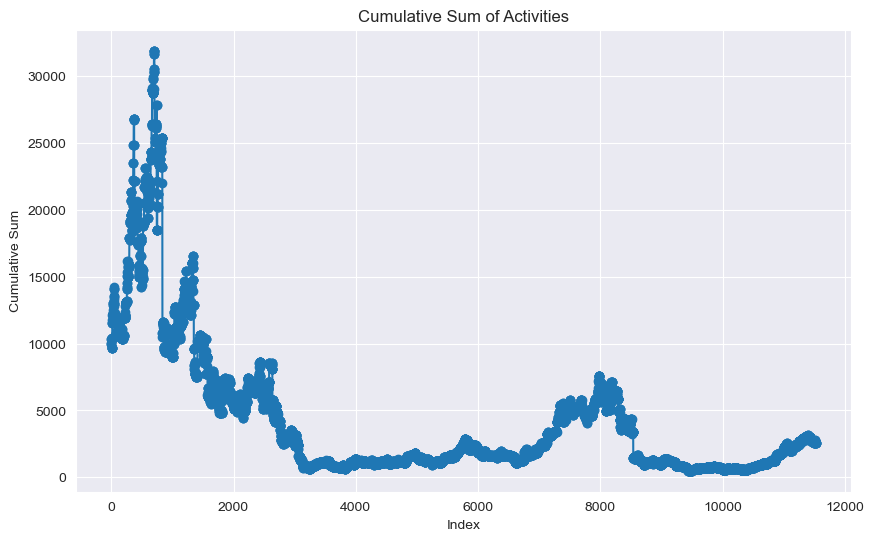

In [266]:
# Evaluate the results
final_portfolio_value = env.cash
returns = env.returns
df_results = pd.DataFrame([vars(trade) for trade in env.close_trades])
metrics = env.metrics
portfolio_values = env.portfolio_values
# Convert the metrics list to a DataFrame and append to dfresult
df_metrics = pd.DataFrame(metrics)
print(df_metrics)
total_result = df_results['result'].sum()
print(total_result)

plt.figure(figsize=(10, 6))
plt.plot(portfolio_values, marker='o')  # Using a marker to show each data point
plt.title('Cumulative Sum of Activities')
plt.xlabel('Index')
plt.ylabel('Cumulative Sum')
plt.grid(True)
plt.show()

## Another extra Implementation of Environment - Remove if you dont want

In [262]:
'''
Keep cash balance & share balance, and update in both trade open and close events.
Can evaluate portfolio value of for each step. Even no any trade is closed, portfolio value is changed when mid_c is changed.
'''
import logging

logging.basicConfig(level=logging.DEBUG)

class StockTradingEnv_2(gym.Env):
    def __init__(self, data, init_cash, init_share,recalc_period, observation_features=None):
        super(StockTradingEnv_2, self).__init__()
        # Define the action space as a 2D vector representing the action type (buy or sell) and number of shares to trade
        self.recalc_period = recalc_period
        self.action_space = gym.spaces.MultiDiscrete([7, 11])  # [action, number of shares]
        self.observation_features = observation_features
        self.observation_space = initialize_observation_space(observation_features)
        
        # Store the historical stock data, initial cash balance, and commission rate as instance variables
        self.data = data
        self.initial_cash = init_cash
        self.initial_share = init_share
        self.end_step = len(self.data) - 1
        self.s = False
        # Reset the environment to its initial state
        self.reset()

    def reset(self,seed=0):
        # Set the current step to 0 and reset the state variables
        self.current_step = 0
        self.profits = 0
        self.returns = []
        self.share = self.initial_share # initial share amount.
        self.share_buy_trade = 0 # tempory shares got from buy trades. Need to calculate portfolio value and change for each trade.
        self.cash = self.initial_cash # initial cash amount.
        self.cash_sell_trade = 0 # tempory cash got from sell trades. Need to calculate portfolio value and change for each trade.
        self.sharpe_ratio = 0
        self.prev_sharpe_ratio = 0
        self.sortino_ratio = 0
        self.max_drawdown = 0
        self.open_trades = []
        self.close_trades = []
        self.done = False
        self.portfolio_values = []
        self.metrics = []
        # Return the initial observation
        return self._get_obs(),{}

    def step(self, action):
        # You can decide what should return by action. For example, I took action type with percentage of cash. then did the rest of implementation
        # If you need to return action type with number of shares, you need to change below if conditions and calculations accordingly.
        # I took cash percentage_to_trade since, it can be valid for any stock. 
        action_type, percentage_to_trade = action
        close_price = self.data.iloc[self.current_step][close]
        prev_close_price = self.data.iloc[self.current_step-1][close]
        
        # Close opposite trades
        if action_signal_map(action_type) != NONE:
            for ot in self.open_trades:
                if ot.is_opposite(action_signal_map(action_type)):
                    if ot.signal == BUY:
                        result = (close_price - ot.start_price) / ot.pip_size
                        profit = (result / ot.risk_per_trade_pips) * ot.trade_amount
                        ot.close_trade(self.data.iloc[self.current_step], result, close_price, 'Opposite_Signal', round(profit, 2))
                    elif ot.signal == SELL:
                        result = (ot.start_price - close_price) / ot.pip_size
                        profit = (result / ot.risk_per_trade_pips) * ot.trade_amount
                        ot.close_trade(self.data.iloc[self.current_step], result, close_price, 'Opposite_Signal', round(profit, 2))
        
        # Update Current trades
        # Update existing trades
        for ot in self.open_trades:
            ot.update(self.data.iloc[self.current_step])
            if not ot.running:
                self.close_trades.append(ot)
                self.profits += ot.profit
                self.returns.append(ot.profit / self.initial_cash)
                if ot.signal == BUY :
                    self.cash += (ot.trigger_price * ot.trade_size_shares)
                    self.share_buy_trade  -= ot.trade_size_shares
                elif ot.signal == SELL:
                    self.share -= ot.trade_size_shares
                    self.cash_sell_trade += (ot.trigger_price * ot.trade_size_shares)
                    
        # Remove closed trades from open trades list
        self.open_trades = [x for x in self.open_trades if x.running]            
        self.update_env_variables(len(self.close_trades))
        # Start new trade
        if action_type != 0:
            cost = self.cash * percentage_to_trade/100
            profit_factor, loss_factor = get_loss_and_profit_factor(action_type)
            if close_price >4:
                pip_size = 0.01
            else:
                pip_size = 0.0001
            if action_type == 1 or action_type == 2 or action_type == 3:
                if self.cash > 0:
                    trade = Trade(self.data.iloc[self.current_step], cost, pip_size, action_signal_map(action_type), profit_factor, loss_factor)
                    self.open_trades.append(trade)
                    self.cash -= cost
                    self.share_buy_trade  += trade.trade_size_shares
            if action_type == 4 or action_type == 5 or action_type == 6:
                    trade = Trade(self.data.iloc[self.current_step], cost, pip_size, action_signal_map(action_type), profit_factor, loss_factor)
                    self.open_trades.append(trade)
                    self.share -= trade.trade_size_shares
                    self.cash_sell_trade += cost
        else:
            pass  # No Trade Action
           
        self.current_step += 1
        # Calculate the total portfolio value
        
        
        # Calculate the reward based on the change in portfolio value at each step. this include cumulative profit.
        # get the percentage because need to add sharp ratio and other rewards. All rewards should be in same range
        reward = self.get_sharpe_ratio_reward() + self.get_portfolio_reward(close_price, prev_close_price) + self.get_cumulative_profit_reward()
        done = (self.current_step == self.end_step)
        # logging.debug(f"Step: {self.current_step}, Cash: {self.cash}, Shares: {self.share}, Reward: {reward}, share_buy_trade: {self.share_buy_trade}, cash_sell_trade {self.cash_sell_trade}, percentage: {percentage_to_trade}")
        return self._get_obs(), reward, done, done, {}

    def _get_obs(self):
        # Calculate the observation vector for the current step
        obs_env_values = [self.cash, self.profits,  self.sharpe_ratio, self.sortino_ratio, self.max_drawdown]
        obs_indicators = [self.data[feature][self.current_step] if feature in self.data else getattr(self, feature) for feature in self.observation_features]
        obs_full = obs_env_values + obs_indicators
        obs_full = np.clip(obs_full, -1e10, 1e10)
        # Return the observation vector as a numpy array
        return np.array(obs_full, dtype=np.float32)
    
    def update_env_variables(self, current_trade_count):
        if current_trade_count % 40 == 0 and current_trade_count > 0:
            self.prev_sharpe_ratio = self.sharpe_ratio
            self.sharpe_ratio = calculate_sharpe_ratio(np.array(self.returns))
            self.sortino_ratio = calculate_sortino_ratio(np.array(self.returns))
            self.max_drawdown = calculate_max_drawdown(np.cumsum(self.returns))
            self.metrics.append({
            'trade_count': len(self.close_trades),
            'sharpe_ratio': self.sharpe_ratio,
            'sortino_ratio': self.sortino_ratio,
            'max_drawdown': self.max_drawdown})
            
    def get_sharpe_ratio_reward(self):
        if self.prev_sharpe_ratio != 0:
            return (self.sharpe_ratio - self.prev_sharpe_ratio)/self.prev_sharpe_ratio
        else:
            return 0
        
    def get_portfolio_reward(self, close_price, prev_close_price):
        portfolio_value = (self.cash + self.cash_sell_trade) + ((self.share+self.share_buy_trade) * close_price)
        self.portfolio_values.append(portfolio_value)
        prev_portfolio_value = (self.cash + self.cash_sell_trade) + ((self.share+self.share_buy_trade) * prev_close_price)
        if prev_portfolio_value != 0:
            return (portfolio_value - prev_portfolio_value)/prev_portfolio_value
        else:
            return 0
    def get_cumulative_profit_reward(self):
        if self.initial_cash != 0:
            return self.profits/self.initial_cash
        else:
            return 0
        
    def set_test_data(self, test_data):    
        self.data = test_data
        self.end_step = len(test_data) - 1

In [263]:
train_size = int(len(df_slim) * 0.8)
train_data = df_slim[:train_size]
test_data = df_slim[train_size:]
test_data.reset_index(drop=True, inplace=True)
# Initialize the environment
init_cash = 10000
init_share = 0
recalc_period = 40
observation_features = ['mid_c', 'SMA7', 'SMA14', 'SMA50', 'EMA7', 'EMA14', 'EMA50', 'EMA200', 'MACD12', 'MACD24', 'ATR12', 'ATR24', 'OBV', 'Lowerband12', 'Upperband12']
env = StockTradingEnv_2(data=train_data, init_cash=init_cash, init_share=init_share, recalc_period=recalc_period, observation_features=observation_features)

# Check if the environment follows the Gym API
check_env(env)

# Create the DQN agent
model = PPO('MlpPolicy', env, verbose=1)

# Train the agent
model.learn(total_timesteps=100)

# Test the agent
env.set_test_data(test_data)
obs,info = env.reset()
done = False
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, truncate, info = env.step(action)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 235  |
|    iterations      | 1    |
|    time_elapsed    | 8    |
|    total_timesteps | 2048 |
-----------------------------


     trade_count  sharpe_ratio  sortino_ratio  max_drawdown
0             80      0.298076       0.293130     -0.845876
1            120      0.222936       0.238512     -0.845876
2            120      0.222936       0.238512     -0.845876
3            160      0.192294       0.210354     -0.845876
4            160      0.192294       0.210354     -0.845876
..           ...           ...            ...           ...
273         9600      0.024287       0.005310     -0.845876
274         9600      0.024287       0.005310     -0.845876
275         9680      0.024186       0.005266     -0.845876
276         9680      0.024186       0.005266     -0.845876
277         9680      0.024186       0.005266     -0.845876

[278 rows x 4 columns]
4561.5999999992755


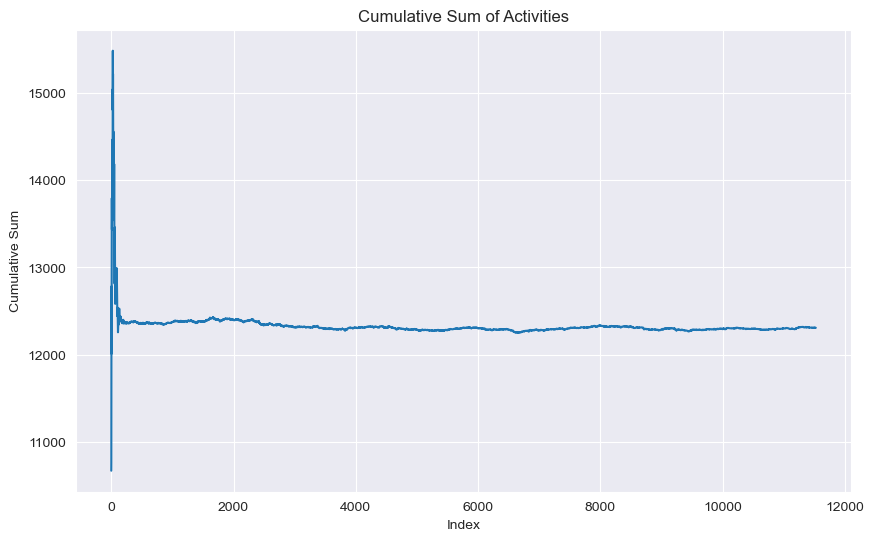

In [264]:
# Evaluate the results
final_cash = env.cash
final_shares = env.share + env.share_buy_trade
final_portfolio_value = final_cash + final_shares * test_data.iloc[env.current_step - 1][close]
returns = env.returns
df_results = pd.DataFrame([vars(trade) for trade in env.close_trades])
metrics = env.metrics
portfolio_values = env.portfolio_values

# Convert the metrics list to a DataFrame and append to dfresult
df_metrics = pd.DataFrame(metrics)
print(df_metrics)
total_result = df_results['result'].sum()
print(total_result)

plt.figure(figsize=(10, 6))
plt.plot(portfolio_values)  # Using a marker to show each data point
plt.title('Cumulative Sum of Activities')
plt.xlabel('Index')
plt.ylabel('Cumulative Sum')
plt.grid(True)
plt.show()